In [1]:
# %run ../Utils/FGindex_function.ipynb
# %run ../Utils/portfolio_metrics.ipynb
# %run ../Utils/Backtesting_function.ipynb

In [2]:
from pykrx import stock
from pykrx import bond

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from operator import itemgetter
from datetime import date, datetime, timedelta
import time

In [4]:
minio_uri = "http://211.55.12.167:8801"
bucket_name = "stock-dataset"

# back testing

In [5]:
def backtesting():
        
    final_result = []
    for ticker in stock.get_index_ticker_list() + stock.get_index_ticker_list(market = "KOSDAQ"):
        
        try:
            # read data
            print("ticker : " + str(ticker) )

            fname = "data_FGscore/{}.csv".format(ticker)
            url = f"{minio_uri}/{bucket_name}/{fname}"
            stock_df = pd.read_csv(url)

            if len(stock_df) > 0:

                stock_df.columns = ["index","datetime","close",'volume','multiple_volume','per','Volatility_list','Volume_list','S1_score','S2_score',"FG_score"]
                stock_df = stock_df.sort_values("datetime").reset_index(drop=True)

                # make candid list
                threshold_list = []
                for b in np.arange (0.1,0.6,0.1):
                    for s in np.arange(0.5,1,0.1):
                        threshold_list.append([b,s])

                best_close = 0
                best_parameter = [0,0] 
                print("market_Score : " + str(stock_df.close[len(stock_df)-1]))

                # auto simul
                for i in threshold_list:

                    tmp,tmp2 = back_testing(stock_df, buying_score = i[0], selling_score = i[1], print_type = False)

                    if best_close < tmp[len(tmp)-1]:
                        best_close = tmp[len(tmp)-1]
                        best_parameter = i
                print("best_Score : " + str(best_close))
                print("threshold : " + str(best_parameter))
                print()

                first_Score = stock_df.close[0]

                market_Score = stock_df.close[len(stock_df)-1]
                final_result.append([ticker, best_parameter[0], best_parameter[1],first_Score, best_close, market_Score])

        except Exception as e:    
            print('예외가 발생했습니다.', e)
                
    return final_result



In [6]:
final_result = backtesting()

ticker : 1001
market_Score : 2441.33
best_Score : 2485.87
threshold : [0.30000000000000004, 0.7999999999999999]

ticker : 1002
market_Score : 2426.39
best_Score : 2426.39
threshold : [0.1, 0.7999999999999999]

ticker : 1003
market_Score : 2704.73
best_Score : 2989.02
threshold : [0.1, 0.7999999999999999]

ticker : 1004
market_Score : 2222.0
best_Score : 2222.0
threshold : [0.1, 0.8999999999999999]

ticker : 1005
market_Score : 3686.27
best_Score : 4206.2
threshold : [0.2, 0.8999999999999999]

ticker : 1006
market_Score : 417.09
best_Score : 1601.0
threshold : [0.1, 0.8999999999999999]

ticker : 1007
market_Score : 364.82
best_Score : 752.29
threshold : [0.1, 0.8999999999999999]

ticker : 1008
market_Score : 5566.48
best_Score : 5444.49
threshold : [0.4, 0.8999999999999999]

ticker : 1009
market_Score : 14642.16
best_Score : 8899.44
threshold : [0.4, 0.8999999999999999]

ticker : 1010
market_Score : 3050.32
best_Score : 7554.32
threshold : [0.2, 0.8999999999999999]

ticker : 1011
market

# output check

In [10]:
from minio import Minio

client = Minio(
    "192.168.0.207:8801",  # URI
    access_key="minioadmin",
    secret_key="minioadmin",
    secure=False)

In [11]:
final_result_df = pd.DataFrame(final_result)

In [12]:
final_result_df.columns = ["ticker", "buying_point","selling_point","first_score","best_score","market_score"] 
final_result_df['per'] = ((final_result_df['best_score']/final_result_df['market_score']))
final_result_df.to_csv("./DATA/index_best_parameter.csv")
FG_score = client.fput_object("stock-dataset", "index_best_parameter.csv", "../DATA/index_best_parameter.csv")

In [13]:
ar = final_result_df.per
mul = 1
for item in ar:
    mul = mul*item
GM = mul ** (1/len(ar))
print("기하 평균 =", GM)

기하 평균 = 1.5278086897534378


# fear greed list

In [18]:

minioClient = Minio(
    "211.55.12.167:8801",  # URI
    access_key="minioadmin",
    secret_key="minioadmin",
    secure=False)

minio_uri = "http://211.55.12.167:8801"
bucket_name = "stock-dataset"


In [22]:
def FG_stock_list():

    fname = "data_index/Stock_list.csv"
    url = f"{minio_uri}/{bucket_name}/{fname}"
    stock_df = pd.read_csv(url)
    
    fname = "index_best_parameter.csv"
    url = f"{minio_uri}/{bucket_name}/{fname}"
    best_parameter = pd.read_csv(url)
    
    stock_list = [(str(i[1]) + str(' : ') +  str(i[2])) for i in stock_df.values if i[1] in list(best_parameter.ticker)]

    middle = []
    greed = []
    fear = []
    for i in stock_df.idx:
        try:
            fname = "data_FGscore/{}.csv".format(str(i))
            url = f"{minio_uri}/{bucket_name}/{fname}"
            FGscore_df = pd.read_csv(url)
            select_FGscore = FGscore_df[FGscore_df.date == (datetime.today() - timedelta(days=1)).strftime("%Y-%m-%d")].FG_score.iloc[0]

            b = best_parameter[best_parameter.ticker == int(i)]
            selling_point = np.round(b.selling_point.iloc[0],1)
            buying_point = np.round(b.buying_point.iloc[0],1)

            if select_FGscore > buying_point and select_FGscore < selling_point:
                middle.append(i)
            elif select_FGscore <=buying_point:
                fear.append(i)
            elif select_FGscore >=selling_point:
                greed.append(i)
        except Exception as e:
            pass
    pd.DataFrame(fear).to_csv("./DATA/today_fear.csv")
    pd.DataFrame(greed).to_csv("./DATA/today_greed.csv")
    
    result = minioClient.fput_object("stock-dataset", "today_fear.csv", "../DATA/today_fear.csv")
    result = minioClient.fput_object("stock-dataset", "today_greed.csv", "../DATA/today_greed.csv")
    
    return fear, greed


In [23]:
FG_stock_list()

([], [1224, 1227, 1232, 1244, 2041, 2068, 2155])

In [24]:
print(len(final_result_df[final_result_df['per'] > 1]))
print(len(final_result_df[final_result_df['per'] == 1]))
print(len(final_result_df[final_result_df['per'] < 1]))

68
11
17


In [28]:
print(np.sum(final_result_df['best_score']))
print(np.sum(final_result_df['market_score']))

335267.88
288581.94


In [31]:
up_df = final_result_df[final_result_df['per'] > 1]
same_df = final_result_df[final_result_df['per'] == 1]
down_df = final_result_df[final_result_df['per'] < 1]

In [32]:
print(len(up_df))
print(len(down_df))
print(len(up_df) / len(final_result_df))

68
17
0.7083333333333334


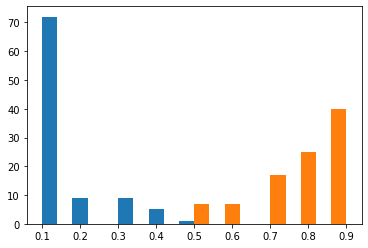

In [34]:
plt.hist(final_result_df.buying_point, bins = 10)
plt.hist(final_result_df.selling_point, bins = 10)
plt.show()